In [1]:
# https://github.com/qlero/vix_index_modelization/blob/master/VIX_modelization.ipynb

In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import requests
import xml.etree.ElementTree as ET

from scipy import interpolate

from yahoo_fin import options as op, stock_info as si
# get_expiration_dates() does not work in Jupyter Notebook
#chain = op.get_expiration_dates("^SPX")

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


Value of the European call option: 8.019103.
Value of the European call option: 7.551576.


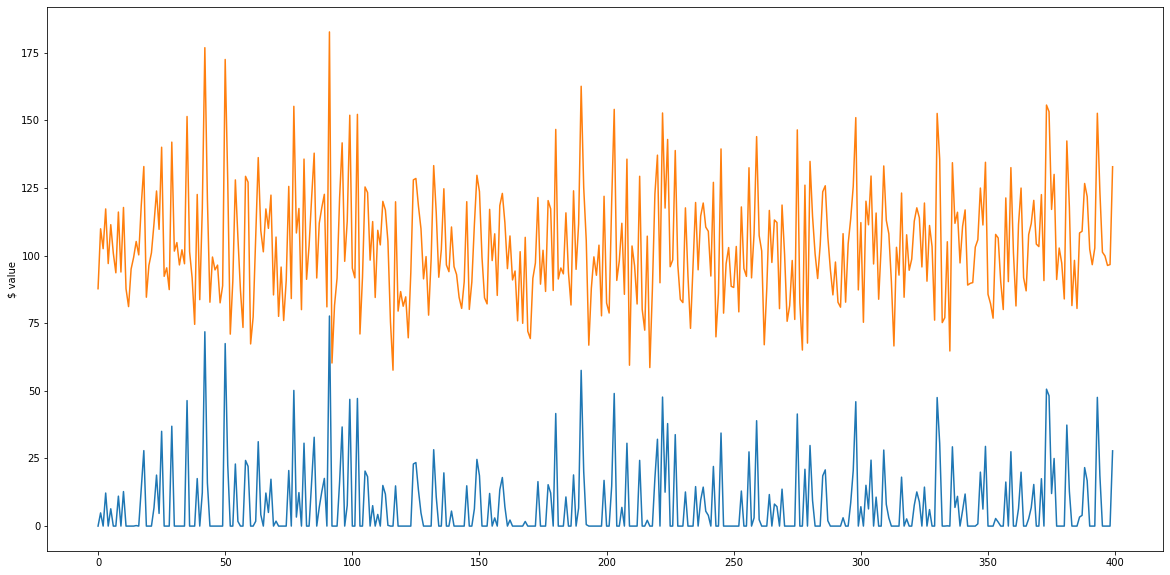

In [5]:
def black_scholes_modelization(stock_pr, strike_pr, maturity, rf_rate, stock_volat, nb_simul, graph = False):
    """
    Modelizes the Black Scholes formula of option pricing based on the common and historic formula
    :param <stock_pr>: Float ; Underlying index/stock price at valuation
    :param <strike_pr>: Float ; Strike price of option
    :param <maturity>: Float ; Time to maturity in years
    :param <rf_rate>: Float ; Risk-free rate
    :param <stock_volat>: Float ; Underlying index/stock volatility
    :param <nb_simul>: Integer ; Number of simulations
    :param <graph>: Boolean ; Boolean to show a graph or not
    """
    S0 = stock_pr
    K = strike_pr
    T = maturity
    r = rf_rate
    sigma = stock_volat
    I = nb_simul
    
    np.random.seed(1000)
    z = np.random.standard_normal(I)
    ST = S0 * np.exp((r-sigma**2/2)*T + sigma * math.sqrt(T)* z) #simulation of index/stock price at maturity
    hT = np.maximum(ST - K, 0) #pay-off at maturity
    
    C0 = math.exp(-r * T) * np.mean(hT) #Monte Carlo estimator
    print("Value of the European call option: {:5.6f}.".format(C0))
    
    if graph == True:
        plt.figure(figsize=(20,10))
        plt.plot(hT)
        plt.plot(ST)
        plt.ylabel('$ value')
        plt.show()

# EXAMPLES
black_scholes_modelization(100., 105., 1.0, 0.05, 0.2, 100000)
black_scholes_modelization(100., 105., 1.0, 0.05, 0.2, 400, True)

The VIX Index Calculation
The generalized formula used in the FIX index calculation is:

$$\sigma^2 = \frac{2}{T}*\sum_{i}\frac{\Delta*K_i*e^{R*T}*Q(K_i)}{K_i^2}-\frac{1}{T}*[\frac{F}{K_0}-1]^2$$
where:

$VIX = \sigma * 100$

$T = \text{time to expiration}$

$F = \text{Forward index level derived from index options prices}$

$K_0 = \text{First strike below the forward index level, F}$

$K_i = \text{Strike price of } i^\text{th} \text{ out-of-the-money option; a call if } K_i &gt; K_0 \text{ and a put if } K_i &lt; K_0 \text{ ; both put and call if } K_i = K_0$

$\Delta*K_i = \text{Interval between strike prices - half the difference between the strike on either side of } K_i$

$$\Delta*K_i = \frac{K_{i+1} - K_{i-1}}{2}$$
$R = \text{Risk-free interest rate to expiration}$

$Q(K_i) = \text{The midpoint of the bid-ask spread for each option with strike }K_i$

Modelling T
The VIX measures 30-day expected volatility of the S&P 500 Index. The components of the VIX are near- and next-term put and call options with more than 23 days and less than 37 days to expiration. These include SPX options with "standard" 3rd Friday expiration dates and "weekly" SPX options that expire every Friday, except the 3rd Friday of each month.
Once each week, the SPX options used to calculate the VIX Index "roll" to new contract maturities (shortest: 24 - 30 day expirations ; latest: 30 - 37 day expirations).

$$T = \frac{M_\text{Current day} + M_\text{Settlement day} + M_\text{Other days}}{\text{Minutes in a year}}$$
where:

$M_\text{Current day} = \text{minutes remaining to midnight of the current day}$

$\text{Either: }M_\text{Settlement day} = \text{minutes from midnight until 08:30am (EST) for "standard" SPX expirations}$

$\text{Or: }M_\text{Settlement day} = \text{minutes from midnight until 04:00pm (EST) for "weekly" SPX expirations}$

$M_\text{Other days} = \text{Total minutes in the days between current day and expiration day}$

$\text{Minutes in a year} = 525600$

Two T values are calculated: $T_1$ for the near-term options, $T_2$ for the next-term options.

#-----------------------------------------------------------------------------------------
VIX 지수 계산 FIX 지수 계산에 사용되는 일반 공식은 다음과 같습니다.

𝜎2=2𝑇∗∑𝑖Δ∗𝐾𝑖∗𝑒𝑅∗𝑇∗𝑄(𝐾𝑖)𝐾2𝑖−1𝑇∗[𝐹𝐾0−1]2
 
어디:

𝑉𝐼𝑋=𝜎*100
𝑇=만료까지의 시간
𝐹=지수 옵션 가격에서 파생된 선도 지수 수준
𝐾0=포워드 지수 F 이하 선제 공격
K_i = \text{행사가 } i^\text{th} \text{ 외가격 옵션; } K_i &gt; K_0 \text{ 및 put if } K_i &lt; K_0 \텍스트{ ; } K_i = K_0인 경우 풋과 콜 모두
Δ*𝐾𝑖=행사가 사이의 간격 - 𝐾𝑖 양쪽의 행사가 차이의 절반
Δ*𝐾𝑖=𝐾𝑖+1−𝐾𝑖−12
 
𝑅=만기까지 무위험 이자율
𝑄(𝐾𝑖)= 행사가 𝐾𝑖가 있는 각 옵션에 대한 매도호가 스프레드의 중간점
모델링 T VIX는 S&P 500 지수의 30일 예상 변동성을 측정합니다. VIX의 구성 요소는 만기가 23일 이상 37일 미만인 단기 및 차기 풋 및 콜 옵션입니다. 여기에는 "표준" 세 번째 금요일 만료 날짜가 있는 SPX 옵션과 매월 세 번째 금요일을 제외하고 매주 금요일 만료되는 "주간" SPX 옵션이 포함됩니다. 매주 한 번 VIX 지수를 계산하는 데 사용되는 SPX 옵션은 새로운 계약 만기로 "롤링"됩니다(최단 만기: 24 - 30일 만기, 가장 늦은 만기: 30 - 37일 만기).

𝑇=𝑀현재일+𝑀결제일+𝑀기타 일1년 중 분
 
어디:

𝑀현재 요일=오늘 자정까지 남은 시간(분)
𝑀정산일="표준" SPX 만료의 경우 자정부터 오전 8시 30분(동부 표준시)까지의 분
또는: 𝑀정산일="주별" SPX 만료의 경우 자정부터 오후 4시(EST)까지의 분
𝑀Other days=현재 날짜와 만료 날짜 사이의 총 시간(분)
1년의 분=525600
단기 옵션의 경우 𝑇1, 다음 옵션의 경우 𝑇2의 두 T 값이 계산됩니다.

In [6]:
def time_to_expiration(term = True):
    """
    Calculates the time to expiration.
    :param <term>: boolean ; True == "Near-term", False == "Next-term"
    """
    #current time + tomorrow
    now = datetime.datetime.now()
    day = datetime.date.today()
    tomorrow = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(1)
    
    #near- or next-term
    if term == True:
        val = 0
    else:
        val = 7
    
    #calculation of minutes remaining until midnight of the current day
    minutes_to_midnight_today = int(round(abs(tomorrow - now).seconds / 60,0))
    
    #calculation of total minutes in the days between current day and expiration day
    for index in range(24,38):
        day = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
        if day.weekday() == 4:
            days_to_expiration = index + val - 1
            if day.weekday() == 4 and 15 <= day.day <= 21:
                minutes_to_settlement = 510
            else:
                minutes_to_settlement = 900
            break
    
    return (minutes_to_midnight_today + minutes_to_settlement + (days_to_expiration) * 24 * 60)/525600


Modelling R
To go with $T_1$ and $T_2$, two risk-free interest rates are also calculated. $R_1$ and $R_2$ are yields based on the US Treasury yield curve rates, also commonly referred to as "Constant Maturity Treasury" rates or CMTs.

Fitting a yield curve using cubic spline:
The goal is to fit a cubic polynomial to the existing yields and maturities of the US Treasury bonds, which together form the "yield curve"--it is actually a discrete list of points in a graph. The goal is to solve a cubic polynomial by minimizing the sum of squared residuals.$$\hat{r}(t) = \beta_0 + \beta_1 * t + \beta_2 * t^2 + \beta_3 * t^3$$

모델링 R 𝑇1 및 𝑇2 를 사용하기 위해 두 개의 무위험 이자율도 계산됩니다. 𝑅1 및 𝑅2는 미국 국채 수익률 곡선 이자율을 기반으로 하는 수익률이며, 일반적으로 "고정 만기 국채" 이자율 또는 CMT라고도 합니다.

3차 스플라인을 사용하여 수익률 곡선 맞추기: 목표는 함께 "수익률 곡선"을 형성하는 미국 재무부 채권의 기존 수익률과 만기에 3차 다항식을 맞추는 것입니다. 이는 실제로 그래프의 개별 포인트 목록입니다. 목표는 잔차 제곱의 합을 최소화하여 3차 다항식을 푸는 것입니다.
𝑟̂ (𝑡)=𝛽0+𝛽1*𝑡+𝛽2*𝑡2+𝛽3*𝑡3

In [7]:
def us_treasury_yield_curve():
    """
    Retrieves and formats the us treasury yield curve.
    No arguments.
    """
    response = requests.get("https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/XmlView.aspx?data=yield")
    root = ET.fromstring(response.content)

    temp_us_treasury_dict={}
    us_treasury_dict={}
    
    for elt in root.iter():
        temp_us_treasury_dict[elt.tag[-8:]] = elt.text
    
    for key in temp_us_treasury_dict.keys():
        if (key.find("MONTH") + key.find("YEAR") + key.find("DATE") != -3):
            us_treasury_dict[re.sub(r'.*_', '', key)] = temp_us_treasury_dict[key]
    
    return us_treasury_dict

In [8]:
def yield_curve_minute_conversion(us_treasury_yields):
    """
    Formats a series of US Treasury yields in minute to expiration
    :param <us_treasury_yields>: dictionary ; contains the list of yield curves of the US treasury bonds
    """
    # Based on the average number of day in a month: 30.42
    minutes_in_a_month = 43804
    minutes_in_a_year = 525600
    
    #minute axis
    x = []
    
    #yield axis
    y = []
    
    #yield_curve_in_minutes = {}
    for key in us_treasury_yields.keys():
        if key.find("MONTH") != -1:
            x.append(int(key[:-5])*minutes_in_a_month)
            y.append(us_treasury_yields[key])
        elif key.find("YEAR") != -1:
            x.append(int(key[:-4])*minutes_in_a_year)
            y.append(us_treasury_yields[key])
    
    return [x,y]

In [9]:

def cubic_spline_risk_free_rate_function(time_to_expiration, minute_data = False):
    """
    Estimates the risk free rate (based on the US treasury yield) at a specific time to expiration
    :param <time_to_expiration>: integer ; time to expiration in day or minutes 
    :param <minute_data>: boolean ; indicates if the argument <time_to_expiration> is in minutes or days
    """
    yield_curve = yield_curve_minute_conversion(us_treasury_yield_curve())
    x_points = yield_curve[0]
    y_points = yield_curve[1]
    tck = interpolate.splrep(x_points, y_points)
    
    if minute_data == False:
        #current time + tomorrow
        now = datetime.datetime.now()
        tomorrow = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(1) 
        
        #calculation of total minutes in the days between current day and expiration day
        for index in range(24,38):
            day = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
            if day.weekday() == 4:
                days_to_expiration = index - 1
                if day.weekday() == 4 and 15 <= day.day <= 21:
                    minutes_to_settlement = 510
                else:
                    minutes_to_settlement = 900
                break
        
        #calculation of minutes remaining until midnight of the current day
        minutes_to_midnight_today = int(round(abs(tomorrow - now).seconds / 60,0))
        time_to_expiration = (time_to_expiration-1) * 24 * 60 + minutes_to_settlement + minutes_to_midnight_today        
        
        return interpolate.splev(time_to_expiration, tck)
    
    else:
        return interpolate.splev(time_to_expiration, tck)

In [10]:
dates = [time_to_expiration(True),time_to_expiration(True)]

estimated_risk_free_rate = []

for date in dates:
    estimated_risk_free_rate.append(float(cubic_spline_risk_free_rate_function(date*525600, True)))


Selecting the options to be used in the VIX Index Calculation
The selected options are out-of-the-money SPX calls and out-of-the-money SPX puts centered around an at-the-money strike price $K_0$. Volatility rises and falls constantly. It implies that the number of options used in the VIX Index calculation may vary from month-to-month, day-to-day, and even minute-to-minute.

Extracting option data and working on them
The goal is to find the "near-term" and "next-term" option strike prices for which, the absolute difference between the call and put prices is the smallest. Those two values will be used to compute a "forward" level, denoted $F$ such as:

$$F = \text{Strike Price} + e^{R * T} * (\text{Call Price} - \text{Put Price})$$
Settlement dates for S&P options occur every two days during the workweek (Monday, Wednesday, Friday). We are looking to extract the option data for the "Near-term" and "next-term" Fridays.

Known issue of yahoo_fin in Jupyter Notebook: the method "get_expiration_date()" does not work due to a Runtime error. Jupyter being an event loop, the method throws the following error: "Cannot use HTMLSession within an existing event loop. Use AsyncHTMLSession instead." To keep this notebook self-contained, we will have to rework the expiration date of each option from their name in the option chain.

VIX 지수 계산에 사용할 옵션 선택 선택한 옵션은 등가격 행사가 𝐾0 을 중심으로 하는 외가격 SPX 콜과 외가격 SPX 풋입니다. 변동성은 끊임없이 상승하고 하락합니다. 이는 VIX 지수 계산에 사용되는 옵션의 수가 월별, 일별, 분 단위로 다를 수 있음을 의미합니다.

옵션 데이터 추출 및 작업 목표는 콜 가격과 풋 가격 간의 절대 차이가 가장 작은 "단기" 및 "차기" 옵션 행사가를 찾는 것입니다. 이 두 값은 다음과 같이 𝐹로 표시된 "순방향" 수준을 계산하는 데 사용됩니다.

𝐹=행사가+𝑒𝑅∗𝑇∗(콜 가격-풋 가격)
 
S&P 옵션의 결제 날짜는 주중(월요일, 수요일, 금요일) 이틀마다 발생합니다. 우리는 "단기" 및 "차기" 금요일에 대한 옵션 데이터를 추출하려고 합니다.

Jupyter Notebook의 알려진 yahoo_fin 문제: 런타임 오류로 인해 "get_expiration_date()" 메서드가 작동하지 않습니다. Jupyter는 이벤트 루프이므로 메서드에서 "기존 이벤트 루프 내에서 HTMLSession을 사용할 수 없습니다. 대신 AsyncHTMLSession을 사용하십시오."라는 오류가 발생합니다. 이 노트북을 독립적으로 유지하려면 옵션 체인에 있는 이름에서 각 옵션의 만료 날짜를 다시 작업해야 합니다.

In [11]:
def get_snp_price():
    """
    Returns the live price of the S&P index.
    No arguments.
    """
    return si.get_live_price("^GSPC")

In [12]:
def day_of_expiration():
    """
    Determines the date of near-term and next-term settlement Fridays.
    No arguments.
    """
    now = datetime.datetime.now()
    
    for index in range(24,38):
        day = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
        if day.weekday() == 4:
            near_term = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index)
            next_term = datetime.datetime(now.year, now.month, now.day) + datetime.timedelta(index+7)
            break
    
    return [near_term, next_term]

In [13]:
def option_chain_v0():
    """
    Return the out of the money SPX calls and puts last price on the market.
    [[{out of the money near-term calls last price}, {out of the money next-term calls last price}], 
    [{out of the money near-term puts last price},{out of the money next-term puts last price}]]
    No arguments.
    """
    dates = day_of_expiration()
    snp_price = get_snp_price()
    call_list = [{},{}]
    put_list = [{},{}]
    for idx1, date in enumerate(dates):
        snp_option_chain = op.get_options_chain("^SPX",str(date.strftime("%x")))
        for idx2, item in enumerate(snp_option_chain["calls"]["Strike"]):
            if item > snp_price:
                call_list[idx1][item] = snp_option_chain["calls"]["Last Price"][idx2]
                
        for idx3, item in enumerate(snp_option_chain["puts"]["Strike"]):
            if item < snp_price:
                put_list[idx1][item] = snp_option_chain["puts"]["Last Price"][idx3]
    return [call_list, put_list]

In [14]:
def option_chain():
    """
    Return the out of the money SPX calls and puts last price on the market.
    [[{out of the money near-term calls last price}, {out of the money next-term calls last price}], 
    [{out of the money near-term puts last price},{out of the money next-term puts last price}]]
    No arguments.
    """
    dates = day_of_expiration()
    snp_price = get_snp_price()
    call_list = [{},{}]
    put_list = [{},{}]
    for idx1, date in enumerate(dates):
        snp_option_chain = op.get_options_chain("^SPX",str(date.strftime("%x")))
        for idx2, item in enumerate(snp_option_chain["calls"]["Bid"]):
            if item != 0:
                call_list[idx1][snp_option_chain["calls"]["Strike"][idx2]] = snp_option_chain["calls"]["Last Price"][idx2]
                
        for idx3, item in enumerate(snp_option_chain["puts"]["Bid"]):
            if item != 0:
                put_list[idx1][snp_option_chain["puts"]["Strike"][idx3]] = snp_option_chain["puts"]["Last Price"][idx3]
    return [call_list, put_list]

In [15]:
def merge_puts_calls_dict(chain):
    """
    Merges out of the money puts and calls by last price and near- or next-term.
    :param <chain>: data structure ; list of lists of dictionaries that contains out of the money, 
        near- and next-term puts and calls last prices
    """
    
    dates = day_of_expiration()
    result = []
    chain = option_chain()
    
    for index, date in enumerate(dates):
        d = {}
        keys = []
        
        for key in set(list(chain[0][index].keys()) + list(chain[1][index].keys())):
            try:
                d.setdefault(key,[]).append(chain[index][0][key])        
            except KeyError:
                pass
            try:
                d.setdefault(key,[]).append(chain[index][1][key])          
            except KeyError:
                pass
        
        for key in d.keys():
            if len(d[key]) != 2: keys.append(key)
        
        for key in keys:
            del d[key]
        
        result.append(d)
    
    return result

In [16]:
def call_put_difference_for_single_strike_white_paper_method():
    """
    Provide the strike price and the associated difference between Call and Put prices, for which it is the smallest.
    This version uses the method explicited in the CBOE white paper.
    No arguments.
    """
    chain = merge_puts_calls_dict(option_chain())
    difference = []
    for term in range(2):
        diff = -1.
        strike= 0.
        for key in chain[term].keys():
            if (diff == -1 or diff > abs(chain[term][key][0] - chain[term][key][1])) and abs(chain[term][key][0] -
                                                                                             chain[term][key][1]) != 0:
                diff = abs(chain[term][key][0] - chain[term][key][1])
                strike = key
        difference.append([strike, diff])
    return difference

In [17]:
def find_F():
    """
    Provide the forward index prices for the near- and next-term options
    No arguments.
    """
    dates = [time_to_expiration(True),time_to_expiration(False)]
    estimate = call_put_difference_for_single_strike_white_paper_method()
    F = []
    for i in range(2):
        F.append(estimate[i][0] + math.exp(estimated_risk_free_rate[i]*dates[i]) * estimate[i][1])
    return F

Determining $K_0$ from the forward index level $F$</b>: <br>From $F$ we can determine $K_{0,1}$ and $K_{0,2}$ (near-term and next-term), the strike price immediately below the forward index level. It is rounded to the closest multiple of 5.

순방향 인덱스 수준 𝐹에서 𝐾0 결정:
𝐹에서 우리는 𝐾0,1 및 𝐾0,2(단기 및 단기), 선도 지수 수준 바로 아래에 있는 행사 가격을 결정할 수 있습니다. 5의 가장 가까운 배수로 반올림됩니다.

In [18]:
def strike_price_under_F():
    """
    Returns the strike price immediately below the forward index level F for the near-and next-term options.
    No arguments.
    """
    dates = day_of_expiration()
    F = find_F()
    K = []
    for counter, date in enumerate(dates):
        snp_option_chain = op.get_options_chain("^SPX",str(date.strftime("%x")))
        strikes = sorted(list(snp_option_chain["puts"]["Strike"])+list(snp_option_chain["calls"]["Strike"]))
        for item in range(1, len(strikes)):
            if strikes[item] > F[counter]:
                K.append(strikes[item-1])
                break
        if len(K) < counter+1: K.append(round(F[counter]-5))
    return K

In [19]:
F_values = find_F()
K = strike_price_under_F()


Selection of the options to be used in the VIX index calculation:
Select out-of-the-money call options with strike prices > $K_{0}$. Start with the put strike immediately higher than $K_{0}$ and move to successively higher strike prices. Exclude any call option that has a bid price equal to zero (i.e. no bid). Once two calls with consecutive strike prices are found to have zero bid prices, no calls with higher strikes are considered for inclusion.

Select out-of-the-money put options with strike prices < $K_{0}$. Start with the put strike immediately higher than $K_{0}$ and move to successively lower strike prices. Exclude any put option that has a bid price equal to zero (i.e. no bid). Once two puts with consecutive strike prices are found to have zero bid prices, no puts with lower strikes are considered for inclusion.

We include the formula below the options value at strike price for ease of use for the next step.

We construct a table that contains the options used to calculate the VIX. We select both the put and call retrieved using the function above along with the put and call average at strike price $K_{0}$. The VIX used the average of quoted bid and ask, or mid-quote, prices for each option selection. The $K_{0}$ put and call prices are average to produce a single value.

We reproduce this method both for near- and next-term.

VIX 지수 계산에 사용할 옵션 선택: 행사가가 > 𝐾0인 외가격 콜 옵션을 선택하십시오. 𝐾0보다 즉시 높은 풋 행사가로 시작하여 계속해서 더 높은 행사가로 이동합니다. 입찰 가격이 0인 모든 콜 옵션을 제외합니다(즉, 입찰가 없음). 연속 행사가가 있는 2개의 통화가 입찰가가 0인 것으로 확인되면 행사가가 더 높은 통화는 포함되지 않습니다.

행사가가 < 𝐾0 인 외가격 풋 옵션을 선택하십시오. 𝐾0보다 즉시 높은 풋 행사가부터 시작하여 행사가를 계속 낮추십시오. 입찰 가격이 0인 모든 풋 옵션을 제외합니다(즉, 입찰가 없음). 행사가가 연속된 2개의 풋옵션이 입찰가가 0인 것으로 확인되면 행사가가 더 낮은 풋옵션은 포함되지 않습니다.

다음 단계에서 사용하기 쉽도록 행사 가격에 옵션 값 아래에 공식을 포함합니다.

VIX를 계산하는 데 사용되는 옵션이 포함된 테이블을 구성합니다. 행사가 𝐾0 에서 풋 및 콜 평균과 함께 위의 함수를 사용하여 검색된 풋 및 콜을 모두 선택합니다. VIX는 각 옵션 선택에 대해 호가 및 매도호가 또는 중간 호가의 평균을 사용했습니다. 𝐾0 풋 및 콜 가격은 단일 값을 생성하기 위한 평균입니다.

우리는 단기 및 다음 기간 모두에 대해 이 방법을 재현합니다.

In [20]:
def retained_options_out_of_the_money():
    """
    Retrieves the out-of-the-money option data: strike, bid, ask
    No arguments.
    """
    dates = day_of_expiration()
    
    call_data = [[[],[],[]],[[],[],[]]]
    put_data = [[[],[],[]],[[],[],[]]]
    
    for date in range(2):
        snp_option_chain = op.get_options_chain("^SPX",str(dates[date].strftime("%x")))
        counter = 0
        for index in range(len(snp_option_chain["calls"]["Strike"])):           
            if snp_option_chain["calls"]["Strike"][index] > K[date]:
                if snp_option_chain["calls"]["Bid"][index] == 0:
                    if counter == 1:
                        break
                    else:
                        counter += 1
                else:
                    counter = 0
                    call_data[date][0].append(snp_option_chain["calls"]["Strike"][index])
                    call_data[date][1].append(snp_option_chain["calls"]["Bid"][index])
                    call_data[date][2].append(snp_option_chain["calls"]["Ask"][index])
        
        counter = 0
        for index in reversed(range(len(snp_option_chain["puts"]["Strike"]))):
            if snp_option_chain["puts"]["Strike"][index] < K[date]:
                if snp_option_chain["puts"]["Bid"][index] == 0:
                    if counter == 1:
                        break
                    else:
                        counter += 1
                else:
                    counter = 0
                    put_data[date][0].append(snp_option_chain["puts"]["Strike"][index])
                    put_data[date][1].append(snp_option_chain["puts"]["Bid"][index])
                    put_data[date][2].append(snp_option_chain["puts"]["Ask"][index])
        
    return [call_data, put_data]

In [21]:

def retained_options_at_the_money():
    """
    Retrieves the at-the-money option data: strike, bid, ask
    No arguments.
    """
    dates = day_of_expiration()
    
    call_data = [[[],[],[]],[[],[],[]]]
    put_data = [[[],[],[]],[[],[],[]]]
    
    for date in range(2):
        snp_option_chain = op.get_options_chain("^SPX",str(dates[date].strftime("%x")))
        try:
            index = list(snp_option_chain["calls"]["Strike"]).index(K[date])
            call_data[date][0] = snp_option_chain["calls"]["Strike"][index]
            call_data[date][1] = snp_option_chain["calls"]["Bid"][index]
            call_data[date][2] = snp_option_chain["calls"]["Ask"][index]
        except Exception as e:
            pass
        try:
            index = list(snp_option_chain["puts"]["Strike"]).index(K[date])
            put_data[date][0] = snp_option_chain["puts"]["Strike"][index]
            put_data[date][1] = snp_option_chain["puts"]["Bid"][index]
            put_data[date][2] = snp_option_chain["puts"]["Ask"][index]
        except Exception as e:
            pass
    
    return [call_data, put_data]


Calculate volatility for both near- and next-term options:
We now need to apply the VIX formula to the near-term andnext-term options with time to expiration $T_{1}$ and $T_{2}$:

$$\sigma^2_{1} = \frac{2}{T_{1}}*\sum_{i}\frac{\Delta*K_i*e^{R_{1}*T_{1}}*Q(K_i)}{K_i^2}-\frac{1}{T_{1}}*[\frac{F_{1}}{K_0}-1]^2$$$$\sigma^2_{2} = \frac{2}{T_{2}}*\sum_{i}\frac{\Delta*K_i*e^{R_{2}*T_{2}}*Q(K_i)}{K_i^2}-\frac{1}{T_{2}}*[\frac{F_{2}}{K_0}-1]^2$$

The VIX index is an amalgam of the information reflected in the prices of all of the selected options. The contribution of a single option to the IX value is proportional to $\Delta*K$ and the price of that option, and inversely proportional to the square of the option's strike price.

How to determine $\Delta*K$: <br>Generally, $\Delta*K_i$ is half the difference between the strike prices on either side of $K_i$. At the upper and lower edges of any given strip of options, $\Delta*K_i$ is simply the difference between $K_i$ and the adjacent strike price. We speak of a near-term options to the index through the following formula:

$$\frac{\Delta*K_i*e^{R_{1}*T_{1}}*Q(K_i)}{K_i^2}$$$$\frac{\Delta*K_i*e^{R_{2}*T_{2}}*Q(K_i)}{K_i^2}$$

A similar calculation is performed for each option. The resulting values for the near-term options are then summed and multiplied by $2/T_1$. Likewise, the resulting values for the next-term options are summed and multiplied by $2/T_2$.

단기 및 단기 옵션 모두에 대한 변동성 계산: 이제 VIX 공식을 만기까지의 시간 𝑇1 및 𝑇2과 함께 단기 및 다음 옵션에 적용해야 합니다.

𝜎21=2𝑇1*∑𝑖Δ*𝐾𝑖*𝑒𝑅1*𝑇1*𝑄(𝐾𝑖)𝐾2𝑖−1𝑇1*[𝐹1𝐾0−1]2
 
𝜎22=2𝑇2*∑𝑖Δ*𝐾𝑖*𝑒𝑅2*𝑇2*𝑄(𝐾𝑖)𝐾2𝑖−1𝑇2*[𝐹2𝐾0−1]2
 
VIX 지수는 선택한 모든 옵션의 가격에 반영된 정보의 조합입니다. IX 가치에 대한 단일 옵션의 기여는 Δ*𝐾 및 해당 옵션의 가격에 비례하고 옵션 행사가의 제곱에 반비례합니다.

Δ*𝐾를 결정하는 방법:
일반적으로 Δ*𝐾𝑖 는 𝐾𝑖 의 양쪽 행사가 차이의 절반입니다. 주어진 옵션 스트립의 상단과 하단에서 Δ*𝐾𝑖는 단순히 𝐾𝑖와 인접한 행사가의 차이입니다. 우리는 다음 공식을 통해 지수에 대한 단기 옵션에 대해 이야기합니다.

Δ*𝐾𝑖*𝑒𝑅1*𝑇1*𝑄(𝐾𝑖)𝐾2𝑖
 
Δ*𝐾𝑖*𝑒𝑅2*𝑇2*𝑄(𝐾𝑖)𝐾2𝑖
 
각 옵션에 대해 유사한 계산이 수행됩니다. 그런 다음 단기 옵션의 결과 값을 합산하고 2/𝑇1 을 곱합니다. 마찬가지로, 다음 기간 옵션에 대한 결과 값을 합산하고 2/𝑇2 를 곱합니다.

In [22]:
def contribution_to_VIX(retained_data_ootm, retained_data_atm, rate):
    """
    Calculates the contribution to the VIX of each single option strip.
    :param <retained_data_ootm>: list ; list of lists containing the out-of-the-money option data 
        retained to calculate the VIX
    :param <retained_data_atm>: list ; list of lists containing the at-the-money option data 
        retained to calculate the VIX
    :param <rate>: float ; estimated risk free rate
    """
    contribution = [[],[]]
    dates = day_of_expiration()
    expiration = [time_to_expiration(True), time_to_expiration(False)]
    
    for date in range(2):
        
        #OUT-OF-THE-MONEY OPTIONS
        delta = {}
        snp_option_chain = op.get_options_chain("^SPX",str(dates[date].strftime("%x")))
        for index, item in enumerate(snp_option_chain["calls"]["Strike"]):
            if item > K[date]:
                if index == 0:
                    delta[item] = abs(snp_option_chain["calls"]["Strike"][index] - 
                                      snp_option_chain["calls"]["Strike"][index+1])
                elif index < len(snp_option_chain["calls"]["Strike"]) - 1:
                    delta[item] = abs(snp_option_chain["calls"]["Strike"][index-1] -
                                      snp_option_chain["calls"]["Strike"][index+1])/2
                else:
                    delta[item] = abs(snp_option_chain["calls"]["Strike"][index] - 
                                      snp_option_chain["calls"]["Strike"][index-1])
        
        for index, item in enumerate(snp_option_chain["puts"]["Strike"]):
            if item < K[date]:
                if index == 0:
                    delta[item] = abs(snp_option_chain["puts"]["Strike"][index] - 
                                      snp_option_chain["puts"]["Strike"][index+1])
                elif index < len(snp_option_chain["puts"]["Strike"]) - 1:
                    delta[item] = abs(snp_option_chain["puts"]["Strike"][index-1] -
                                      snp_option_chain["puts"]["Strike"][index+1])/2
                else:
                    delta[item] = abs(snp_option_chain["puts"]["Strike"][index] - 
                                      snp_option_chain["puts"]["Strike"][index-1])
        for index in range(len(retained_data_ootm[0][date][0])):
            try:
                contrib = (2/expiration[date])*delta[retained_data_ootm[0][date][0][index]]/(K[date]**2)*\
                math.exp(rate[date]/100*expiration[date])*\
                abs(float(retained_data_ootm[0][date][1][index])-float(retained_data_ootm[0][date][2][index]))
                contribution[date].append(contrib)
            except Exception as e: 
                print(e)
        for index in range(len(retained_data_ootm[1][date][0])):
            try:
                contrib = (2/expiration[date])*delta[retained_data_ootm[1][date][0][index]]/(K[date]**2)*\
                math.exp(rate[date]/100*expiration[date])*\
                abs(float(retained_data_ootm[1][date][1][index])-float(retained_data_ootm[1][date][2][index]))
                contribution[date].append(contrib)
            except Exception as e: 
                print(e)
        #AT-THE-MONEY OPTIONS
        if isinstance(retained_data_atm[0][date][0],np.float64) == False:
            if isinstance(retained_data_atm[1][date][0],np.float64):
                try:
                    contrib = (2/expiration[date])*abs(delta[retained_data_ootm[1][date][0][index]])/(K[date]**2)*\
                            math.exp(rate[date]/100*expiration[date])*\
                            abs(float(retained_data_atm[1][date][1])-float(retained_data_atm[1][date][2]))
                    contribution[date].append(contrib)
                except Exception as e: 
                    print(e)
        else:
            if isinstance(retained_data_atm[1][date][0],np.float64) == False:
                try:
                    contrib = (2/expiration[date])*abs(delta[retained_data_ootm[1][date][0][index]])/(K[date]**2)*\
                    math.exp(rate[date]/100*expiration[date])*\
                    abs(float(retained_data_atm[0][date][1])-float(retained_data_atm[0][date][2]))
                    contribution[date].append(contrib)
                except Exception as e: 
                    print(e)
            else:
                try:
                    contrib = (2/expiration[date])*abs(delta[retained_data_ootm[1][date][0][index]])/(K[date]**2)*\
                            math.exp(rate[date]/100*expiration[date])*\
                            (abs(float(retained_data_atm[0][date][1])-float(retained_data_atm[0][date][2]))+\
                             abs(float(retained_data_atm[1][date][1])-float(retained_data_atm[1][date][2])))/2
                    contribution[date].append(contrib)
                except Exception as e: 
                    print(e)
    return contribution

In [23]:
rates = estimated_risk_free_rate
retained_options_ootm = retained_options_out_of_the_money()
retained_options_atm = retained_options_at_the_money()

near_term_sum_of_contribution = sum(contribution_to_VIX(retained_options_ootm, retained_options_atm, rates)[0])
next_term_sum_of_contribution = sum(contribution_to_VIX(retained_options_ootm, retained_options_atm, rates)[1])

could not convert string to float: '-'
could not convert string to float: '-'
list index out of range
list index out of range
could not convert string to float: '-'
could not convert string to float: '-'
list index out of range
list index out of range



Next we calculate:$$\frac{1}{T_{1}}*[\frac{F_{1}}{K_0}-1]^2$$and$$\frac{1}{T_{2}}*[\frac{F_{2}}{K_0}-1]^2$$

In [24]:
expiration = [time_to_expiration(True), time_to_expiration(False)]

near_term_time_component = 1 / expiration[0] * (F_values[0] / K[0] - 1)**2
next_term_time_component = 1 / expiration[1] * (F_values[1] / K[1] - 1)**2

Now we can calculate $\sigma^2_{1}$ and $\sigma^2_{2}$:

In [25]:

near_term_sigma_squared = near_term_sum_of_contribution - near_term_time_component
next_term_sigma_squared = next_term_sum_of_contribution - next_term_time_component

Calculate the VIX
We calculate the 30-day weighted average of $\sigma^2_{1}$ and $\sigma^2_{2}$, then take the square root of the value and multiply by 100 to get the VIX value:

$$VIX = 100 * \sqrt{(T_1 * \sigma^2_{1}*\frac{N_{T_2}-N_{30}}{N_{T_2}-N_{T_1}} + T_1 * \sigma^2_{2}*\frac{N_{30}-N_{T_1}}{N_{T_2}-N_{T_1}}) * \frac{N_{365}}{N_{30}}}$$

where:

$N_{T_1}$ = number of minutes to settlement of the near-term options

$N_{T_2}$ = number of minutes to settlement of the next-term options

$N_{30}$ = number of minutes in 30 days (i.e. 43,200)

$N_{365}$ = number of minutes in a 365-day year (i.e. 525,600)

VIX 계산 30일 가중 평균 𝜎21 및 𝜎22 를 계산한 다음 값의 제곱근을 취하고 100을 곱하여 VIX 값을 얻습니다.

𝑉𝐼𝑋 = 100 * (σ21 𝑇1 * * - 𝑁𝑇2 𝑁30𝑁𝑇2-𝑁𝑇1 𝑇1 * + * σ22 𝑁30-𝑁𝑇1𝑁𝑇2-𝑁𝑇1) * 𝑁365𝑁30⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯ ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯ ⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯⎯√
 
어디:

𝑁𝑇1 = 단기 옵션 결제까지 남은 시간(분)

𝑁𝑇2 = 차기 옵션 결제까지 남은 시간(분)

𝑁30 = 30일 동안의 분 수(예: 43,200)

𝑁365 = 1년 365일의 분 수(예: 525,600)

In [26]:

near_term_minutes = time_to_expiration(True) * 525600
next_term_minutes = time_to_expiration(False) * 525600
month_minutes = 43200
year_minutes = 525600

In [27]:
VIX = round(100 * math.sqrt((time_to_expiration(True) * near_term_sigma_squared * 
                      ((next_term_minutes - month_minutes)/(next_term_minutes - near_term_minutes)) + 
                     time_to_expiration(False) * next_term_sigma_squared * 
                      ((month_minutes - near_term_minutes)/(next_term_minutes - near_term_minutes))) * 
                     (year_minutes / month_minutes)),2)
print(f"The VIX index is estimated at: {VIX}.")

ValueError: math domain error


Conclusion
As at July 25th, 2019, the calculated VIX is of 11.04, compared to a market-provided 12.4.

The discrepancy can be explained by the incompleteness of the data available through the Yahoo finance module. It does not always provide puts and calls with the same strike price. This makes hard to calculate an actual VIX as the first step of the calculation (determining the forward SPX level F for the near- and next-term expirations) requires calls and puts of similar strike price. This forces us to exclude otherwise valuable option data, which renders the calculation incomplete. The approximation remains nonetheless valuable for understanding how the index is built.

결론 2019년 7월 25일 현재 계산된 VIX는 시장에서 제공하는 12.4와 비교하여 11.04입니다.

불일치는 Yahoo 금융 모듈을 통해 사용할 수 있는 데이터의 불완전성으로 설명할 수 있습니다. 항상 동일한 행사가로 풋 및 콜을 제공하는 것은 아닙니다. 이는 계산의 첫 번째 단계(가까운 만기 및 다음 만기에 대한 선도 SPX 수준 F 결정)에 유사한 행사가의 콜 및 풋이 필요하기 때문에 실제 VIX를 계산하기 어렵게 만듭니다. 이것은 우리가 계산을 불완전하게 만드는 다른 중요한 옵션 데이터를 제외하도록 강요합니다. 그럼에도 불구하고 근사치는 인덱스가 어떻게 구축되는지 이해하는 데 여전히 중요합니다.